In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import Model


**Getting the stock price history data**

load the data and inspect it:

In [2]:
df=pd.read_csv("TSLA.csv")

print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


 **Load the data and inspect them**

In [3]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values
print(training_set[:5])

[[52.444   ]
 [52.450001]
 [52.419998]
 [53.348   ]
 [52.844002]]


**normalize and reshape**

We want our data to be in the form of a 3D array for our LSTM model. First, we create data in 60 timesteps and convert it into an array using NumPy. Then, we convert the data into a 3D array with X_train samples, 60 timestamps, and one feature at each step.

In [4]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])   # when i-60, r1 - values from idx_0 to idx_60
                                              # when i-61, r2 - values from idx_1 to idx_61
    y_train.append(training_set_scaled[i, 0])                          # r1 -> y_1 - value in idx_61
                                              # r2 -> y_2 - value in idx_62

# [10,20,30,40,50,60,70,80]
# timesteps = 3 
# r1 = [10,20,30] -> y_1 = 40
# r2 = [20,30,40] -> y_2 = 50
# r3 = [30,40,50] -> y_3 = 60
# and so on...
        
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

# we need [samples, timesteps, features]
# 1-dimensional features -> scalar value -> features - 1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape)

(740, 60) (740,)
(740, 60, 1)


**Now, it’s time to build the model**

Add LSTM layer along with dropout layers to prevent overfitting. After that, we add a Dense layer that specifies a one unit output. Next, we compile the model using the adam optimizer and set the loss as the mean_squarred_error


In [5]:
#DO with GRU also
model = Sequential()#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units=50))
model.add(Dropout(0.2))# Adding the output layer
model.add(Dense(1))

# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#add checkpoint to save model

# Fitting the LSTM to the Training set
model.fit(X_train, y_train, epochs=10, batch_size=32)

2022-05-19 10:23:13.022844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-19 10:23:13.022859: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-19 10:23:13.022870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (80d80221f392): /proc/driver/nvidia/version does not exist
2022-05-19 10:23:13.022991: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 10:23:13.375134: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Epoch 1/10
24/24 [==============================] - 3s 39ms/step - loss: 0.0460
Epoch 2/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0147
Epoch 3/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0121
Epoch 4/10
24/24 [==============================] - 1s 37ms/step - loss: 0.0121
Epoch 5/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0118
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0110
Epoch 7/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0114
Epoch 8/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0110
Epoch 9/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0098
Epoch 10/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0098


**Prepare the test data (reshape them)**

In [6]:
# Getting the predicted stock price for testing
dataset_train = df.iloc[:800, 1:2]
dataset_train.to_csv("dataset_train.csv")
dataset_test = df.iloc[800:, 1:2]
dataset_test.to_csv("dataset_test.csv")

dataset_total = pd.concat((dataset_train, dataset_test), axis=0)
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total)-len(dataset_test)-60:].values
inputs = inputs.reshape(-1,1)
print(inputs.shape)

inputs = sc.transform(inputs)
X_test = []

for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
print(X_test.shape)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(1259, 1)
(519, 1)
(459, 60)
(459, 60, 1)


**Make Predictions using the test set**

In [7]:
predicted_stock_price = model.predict(X_test)
print(predicted_stock_price.shape)

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(predicted_stock_price[:3])

(459, 1)
[[62.67837 ]
 [61.934303]
 [61.22116 ]]


**Visualize the results**

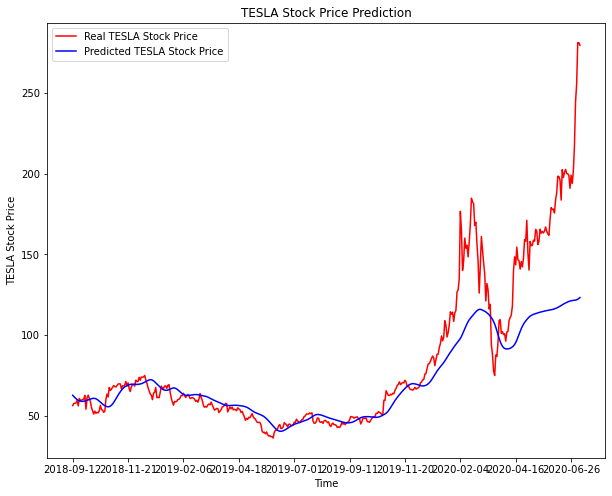

In [8]:
# Visualising the results
plt.figure(figsize=(10,8))
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

**Observation**: Huge drop in March 2020 due to the COVID-19 lockdown !

We can clearly see that our model performed very good. It is able to accuretly follow most of the unexcepted jumps/drops however, for the most recent date stamps, we can see that the model expected (predicted) lower values compared to the real values of the stock price.

**Prepare data for a MLP model**

In [9]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled_nn = sc.fit_transform(training_set)# Creating a data structure with 60 time-steps and 1 output
X_train_nn = []
y_train_nn = []

for i in range(60, 800):
    X_train_nn.append(training_set_scaled_nn[i-60:i, 0])
    y_train_nn.append(training_set_scaled_nn[i, 0])

X_train_nn, y_train_nn = np.array(X_train_nn), np.array(y_train_nn)

print(X_train_nn.shape, y_train_nn.shape)


(740, 60) (740,)


**MLP model**

In [10]:
model_nn = keras.Sequential()
model_nn.add(Dense(256, activation='relu', input_dim=60)) #input_shape
model_nn.add(Dense(512, activation='relu'))
model_nn.add(Dense(256, activation='relu')) 
model_nn.add(Dense(128, activation='relu')) 
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(1))

model_nn.compile(optimizer='adam',loss='mean_squared_error')
model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               15616     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 319,745
Trainable params: 319,745
Non-trainable params: 0
________________________________________________

In [11]:
model_nn.fit(X_train_nn,y_train_nn,epochs=10,batch_size=32)

Epoch 1/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0172
Epoch 2/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 3/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 4/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 5/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 6/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 7/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 8/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 9/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 10/10
24/24 [==============================] - 0s 1ms/step - loss: 0.0017


**Prepare test set for MLP model**

In [12]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test_nn = []
for i in range(60, 519):
    X_test_nn.append(inputs[i-60:i, 0])
X_test_nn = np.array(X_test_nn)

print(X_test_nn.shape)

(459, 60)


In [13]:
predicted_stock_price_nn_init = model_nn.predict(X_test_nn)
predicted_stock_price_nn = sc.inverse_transform(predicted_stock_price_nn_init)

print(predicted_stock_price_nn[:3])



[[53.99927 ]
 [54.211426]
 [54.75356 ]]


**Visualize the results**

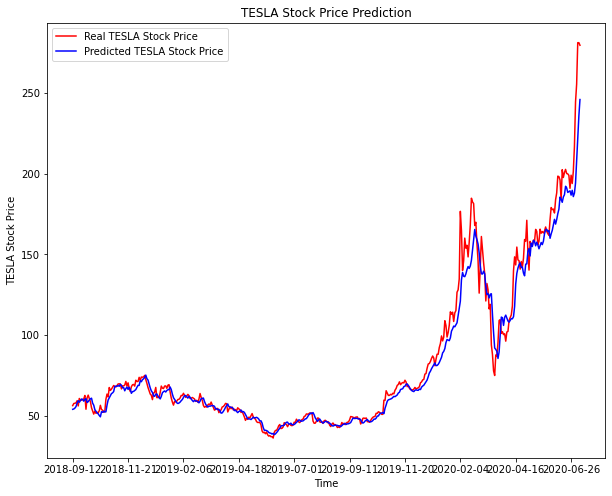

In [14]:
# Visualising the results
plt.figure(figsize=(10,8))
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price_nn, color = "blue", label = "Predicted TESLA Stock Price")
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

**Multi step predictions**


[10, 20, 30, 40, 50, 60, 70, 80, 90]

input : [10,20,30]
output: [40,50]

In [15]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)# Creating a data structure with 60 time-steps and 2 steps into the future
X_train = []
y_train = []

for i in range(60, 800-2):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i:i+2, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(y_train[0])
print(X_train.shape[0], X_train.shape[1], X_train.shape[2])

[0.43589644 0.39972175]
738 60 1


In [16]:
#TO DO:
model = Sequential()#Adding the first LSTM layer and some Dropout regularisation 
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))      #n_features is still 1. each time time is represented by 1 number only
                                                                                                #n_steps_in = X_train.shape[1]

model.add(Dropout(0.2))# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))# Adding the output layer
model.add(Dense(2)) #n_steps_out = 2 

# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the LSTM to the Training set
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
24/24 [==============================] - 3s 40ms/step - loss: 0.0898
Epoch 2/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0239
Epoch 3/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0162
Epoch 4/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0158
Epoch 5/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0147
Epoch 6/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0154
Epoch 7/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0124
Epoch 8/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0141
Epoch 9/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0117
Epoch 10/10
24/24 [==============================] - 1s 33ms/step - loss: 0.0124


**Prepare the test set**

In [17]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(459, 60, 1)


**Make predictions**

In [18]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(predicted_stock_price.shape)
print(predicted_stock_price[:3])

(459, 2)
[[60.310528 60.420177]
 [59.690987 59.786476]
 [59.076843 59.164787]]


**Visualize the results**

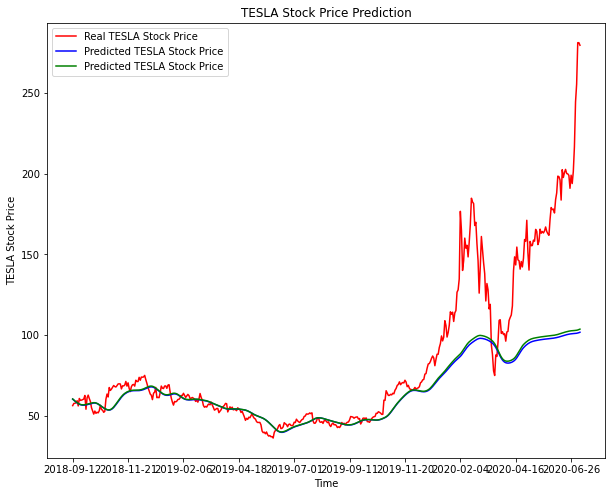

In [19]:
# Visualising the results
plt.figure(figsize=(10,8))
plt.plot(df.loc[800:, "Date"],dataset_test.values, color = "red", label = "Real TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price[:,0], color = "blue", label = "Predicted TESLA Stock Price")
plt.plot(df.loc[800:, "Date"],predicted_stock_price[:,1], color = "green", label = "Predicted TESLA Stock Price")

plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

**Multivariate**

In [20]:
#multivariate
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [21]:
df["average"] = (df["High"] + df["Low"])/2
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,average
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500,52.081998
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500,51.859999
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000,52.650002
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000,52.957000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000,53.036000


**Prepare the training data**

In [22]:
input_features =  df.iloc[:800,[6,7]].values
input_features[:5]


array([[1.30545000e+07, 5.20819985e+01],
       [1.48015000e+07, 5.18599985e+01],
       [9.53800000e+06, 5.26500015e+01],
       [1.01080000e+07, 5.29570005e+01],
       [8.08000000e+06, 5.30359995e+01]])

In [23]:
print(input_features[:5,1])

[52.0819985 51.8599985 52.6500015 52.9570005 53.0359995]


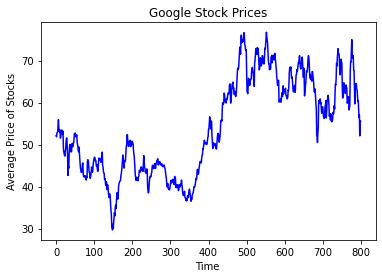

In [24]:
plt.plot(input_features[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time ")
plt.ylabel("Average Price of Stocks")
plt.show()

**Normalize**

In [25]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_features_scaled = sc.fit_transform(input_features)

print(input_features_scaled[:5,1])
input_features_scaled[:7]

[0.47624206 0.47152448 0.48831233 0.49483618 0.49651493]


array([[0.06307719, 0.47624206],
       [0.07465907, 0.47152448],
       [0.03976425, 0.48831233],
       [0.04354312, 0.49483618],
       [0.03009832, 0.49651493],
       [0.1424068 , 0.52505424],
       [0.14155822, 0.55777978]])

**Split data in sequences**

In [26]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)- n_steps -1):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y) 
 
X, y = split_sequences(input_features_scaled,3)

In [27]:
print(X[0], y[0])

[[0.06307719 0.47624206]
 [0.07465907 0.47152448]
 [0.03976425 0.48831233]] 0.49483617562543913


In [28]:
print(X[1], y[1])

[[0.07465907 0.47152448]
 [0.03976425 0.48831233]
 [0.04354312 0.49483618]] 0.4965149337358694


In [29]:
print(X[2], y[2])

[[0.03976425 0.48831233]
 [0.04354312 0.49483618]
 [0.03009832 0.49651493]] 0.5250542359954287


**Split and Reshape**

In [30]:
X, y = split_sequences(input_features_scaled,60)
X, y= np.array(X), np.array(y)

print(X.shape, y.shape)


(739, 60, 2) (739,)


**Build LSTM for multivariate case**

In [31]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=30, return_sequences= True, input_shape=(X.shape[1], X.shape[2])))
model.add(keras.layers.LSTM(units=30, return_sequences= True))
model.add(keras.layers.LSTM(units=30))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model.fit(X, y, epochs=20, batch_size=32)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 30)            3960      
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 30)            7320      
_________________________________________________________________
lstm_10 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
24/24 [==============================] - 2s 27ms/step - loss: 0.0557
Epoch 2/20
24/24 [==============================] - 1s 25ms/step - loss: 0.0101
Epoch 3/20
24/24 [==============================] - 1s 26ms/step - loss: 0.0095
Epoch 4/

**Prepare testing set**

In [32]:
input_features_test =  df.iloc[800:,[6,7]].values
input_features_test[:5]
#normalization
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_features_test_scaled = sc.fit_transform(input_features_test)

print(input_features_test_scaled[:5,1])
input_features_test_scaled[:7]
#TO DO
X_test, y_test = split_sequences(input_features_test_scaled,60)
print(X_test.shape, y_test.shape)

predicted_value= model.predict(X_test)

[0.08635861 0.09011713 0.09164468 0.09378824 0.08926802]
(398, 60, 2) (398,)


**Visualize**

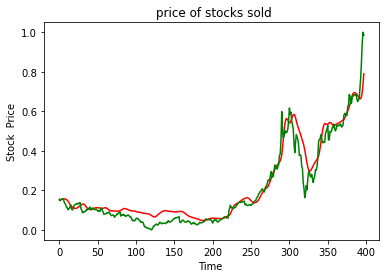

In [33]:
plt.plot(predicted_value, color= 'red')
plt.plot(y_test, color='green')
plt.title(" price of stocks sold")
plt.xlabel("Time ")
plt.ylabel("Stock  Price")
plt.show()

**Multivariate multistep: to do as homework**